## Problem 3 - Event based approach

In [128]:
import numpy as np
import pandas as pd

# Define event types to avoid using magic strings
Q1_ARR = "Q1_ARR"
Q1_DONE = "Q1_DONE"
Q2_DONE = "Q2_DONE"

class EventQueue:
    def __init__(self):
        self.queue = {}
        self.passed_events = []
        self.current_time = 0
    
    def plan_q1_arr(self):
        self.queue[self.current_time + 3600 * np.random.exponential(1/100)] = Q1_ARR
    
    def plan_q1_done(self):
        self.queue[self.current_time + 3600 * np.random.exponential(1/200)] = Q1_DONE
    
    def plan_q2_done(self):
        self.queue[self.current_time + 3600 * np.random.exponential(1/110)] = Q2_DONE

    def get_next_event(self):
        # Find next event scheduled in the future
        event_times = sorted(self.queue.keys())
        # Remove events that are in the past or now
        event_times = [t for t in event_times if t > self.current_time]

        # Get the next event
        next_event_time = event_times[0]

        # Get the event type
        event_type = self.queue[next_event_time]

        # Add the event to the passed events
        self.passed_events.append((next_event_time, event_type))
        # Remove the event from the queue
        del self.queue[next_event_time]
        # Update the current time
        self.current_time = next_event_time
        return next_event_time, event_type



def simulate(N=10000):
    queue = EventQueue()
    # Initialize the first event
    queue.plan_q1_arr()
    cars_left = 0

    # Initialize the number of cars in each queue
    q1 = 0
    q2 = 0

    while cars_left < N:
        time, event_type = queue.get_next_event()

        if event_type == Q1_ARR:
            q1 += 1
            if q1 == 1 and q2 < 10:
                queue.plan_q1_done()
            
            queue.plan_q1_arr()

        elif event_type == Q1_DONE:
            q1 -= 1
            q2 += 1

            if q1 != 0 and q2 < 10:
                queue.plan_q1_done()
            
            if q2 == 1:
                queue.plan_q2_done()
        
        elif event_type == Q2_DONE:
            cars_left += 1
            q2 -= 1
            if q2 == 9 and q1 > 0:
                # q2 was just full, but isn't anymore
                # and someone is waiting in q1
                queue.plan_q1_done()
            if q2 != 0:
                queue.plan_q2_done()
    
    return queue

def simulate_df(*args):
    event_queue = simulate(*args)

    df_data = []

    arrived, q1, q2, q1_done, q2_done = 0, 0, 0, 0, 0

    for event_time, event_type in event_queue.passed_events:
        if event_type == Q1_ARR:
            q1 += 1
            arrived += 1
        elif event_type == Q1_DONE:
            q1 -= 1
            q1_done += 1
            q2 += 1
        elif event_type == Q2_DONE:
            q2 -= 1
            q2_done += 1
        
        df_data.append((event_time/60/60, event_type, q1, q2, arrived, q1_done, q2_done))

    return pd.DataFrame(df_data, columns=["time", "event_type", "q1", "q2", "arrived", "q1_done", "q2_done"])

simulate_df(10000)

,time,event_type,q1,q2,arrived,q1_done,q2_done
0,0.004722,Q1_ARR,1,0,1,0,0
1,0.008334,Q1_DONE,0,1,1,1,0
2,0.015114,Q1_ARR,1,1,2,1,0
3,0.018149,Q2_DONE,1,0,2,1,1
4,0.019697,Q1_DONE,0,1,2,2,1
...,...,...,...,...,...,...,...
30001,99.550563,Q1_DONE,2,3,10003,10001,9998
30002,99.555259,Q2_DONE,2,2,10003,10001,9999
30003,99.555943,Q1_ARR,3,2,10004,10001,9999
30004,99.558389,Q1_DONE,2,3,10004,10002,9999


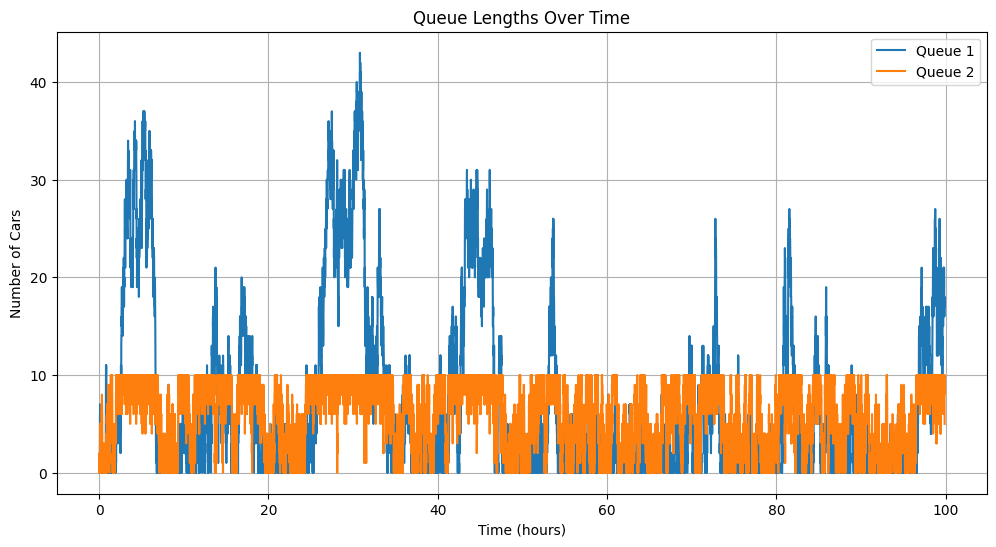

In [129]:
import matplotlib.pyplot as plt

df = simulate_df(10000)

plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["q1"], label="Queue 1")
plt.plot(df["time"], df["q2"], label="Queue 2")
plt.xlabel("Time (hours)")
plt.ylabel("Number of Cars")
plt.title("Queue Lengths Over Time")
plt.legend()
plt.grid()
plt.show()

In [130]:
df = simulate_df(10000)

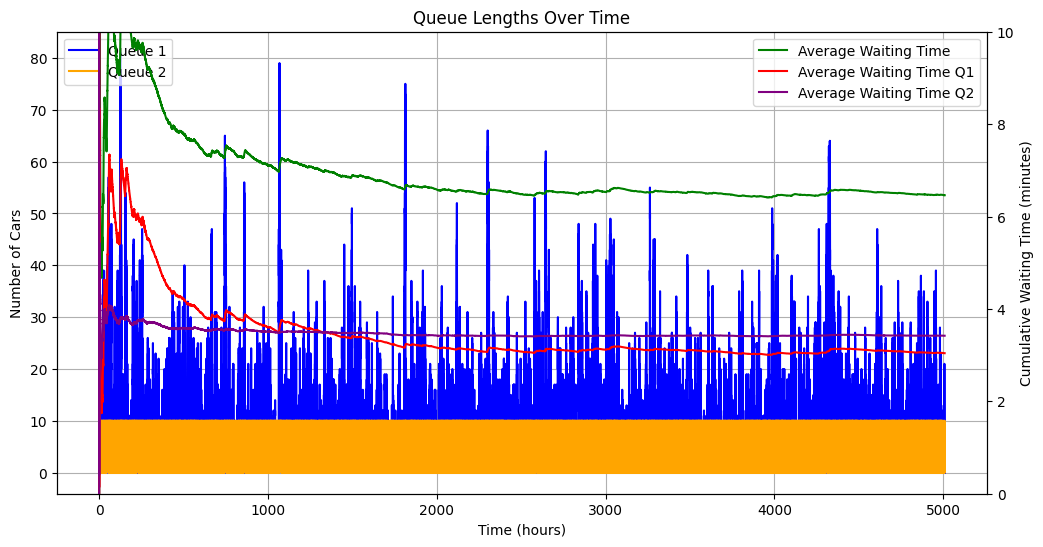

In [131]:
df = simulate_df(500000)
# Calculate the total time spent in the system for each car
df["time_since_last_event"] = df["time"].diff().fillna(0)

df["inter_waiting_time_q1"] = df["time_since_last_event"] * df["q1"].shift(1).fillna(0)
df["inter_waiting_time_q2"] = df["time_since_last_event"] * df["q2"].shift(1).fillna(0)
df["inter_waiting_time"] = df["inter_waiting_time_q1"] + df["inter_waiting_time_q2"]

df["cumulative_waiting_time_q1"] = df["inter_waiting_time_q1"].cumsum()
df["cumulative_waiting_time_q2"] = df["inter_waiting_time_q2"].cumsum()
df["cumulative_waiting_time"] = df["inter_waiting_time"].cumsum()
# Calculate the average waiting time at each point in time
df["average_waiting_time"] = df["cumulative_waiting_time"] / (df["arrived"].shift(1).fillna(0) + 1e-10)
df["average_waiting_time_q1"] = df["cumulative_waiting_time_q1"] / (df["q1_done"].shift(1).fillna(0) + 1e-10)
df["average_waiting_time_q2"] = df["cumulative_waiting_time_q2"] / (df["q2_done"].shift(1).fillna(0) + 1e-10)

# Plot the cumulative waiting time on top of the queue lengths using seperate y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df["time"], df["q1"], label="Queue 1", color='blue')
ax1.plot(df["time"], df["q2"], label="Queue 2", color='orange')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Number of Cars")
ax1.set_title("Queue Lengths Over Time")
ax1.legend(loc='upper left')
ax2.plot(df["time"], df["average_waiting_time"] * 60, label="Average Waiting Time", color='green')
ax2.plot(df["time"], df["average_waiting_time_q1"] * 60, label="Average Waiting Time Q1", color='red')
ax2.plot(df["time"], df["average_waiting_time_q2"] * 60, label="Average Waiting Time Q2", color='purple')\

# Limit the average queue time axis to max 10 minutes
ax2.set_ylim(0, 10)

ax2.set_ylabel("Cumulative Waiting Time (minutes)")
ax2.legend(loc='upper right')
ax1.grid()
plt.show()

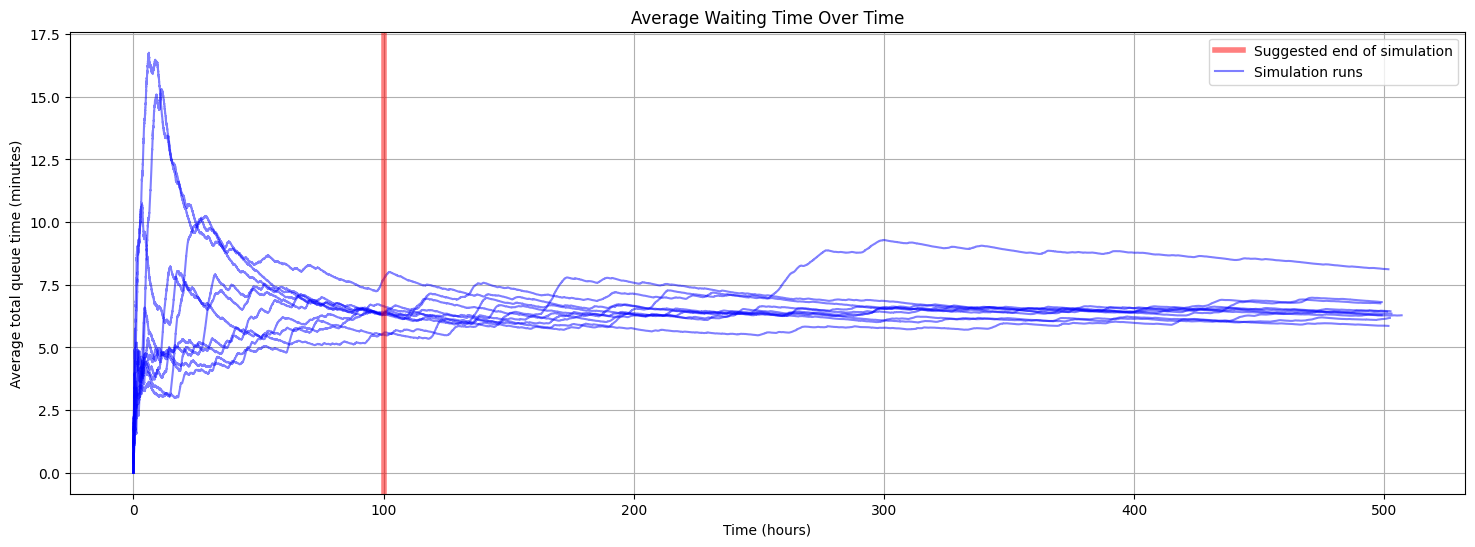

In [132]:
plt.figure(figsize=(18, 6))

# Do 5 simulation and plot the average waiting time for each simulation
for i in range(10):
    df = simulate_df(10000 * 5)
    df["time_since_last_event"] = df["time"].diff().fillna(0)
    df["inter_waiting_time"] = df["time_since_last_event"] * (df["q1"].shift(1).fillna(0) + df["q2"].shift(1).fillna(0))
    df["cumulative_waiting_time"] = df["inter_waiting_time"].cumsum()
    # Calculate the average waiting time at each point in time
    df["average_waiting_time"] = df["cumulative_waiting_time"] / (df["arrived"].shift(1).fillna(0) + 1e-10)

    plt.plot(df["time"], df["average_waiting_time"] * 60, color='blue', alpha=0.5)


# Draw vertical line at 100 hours (suggested end of simulation)
plt.axvline(x=100, color='red', label='Suggested end of simulation', linewidth=4, alpha=0.5)
# Add a legend entry to show that blue lines represent simulation runs
plt.plot([], [], color='blue', label='Simulation runs', alpha=0.5)

plt.xlabel("Time (hours)")
plt.ylabel("Average total queue time (minutes)")
plt.title("Average Waiting Time Over Time")
plt.legend()
plt.grid()
plt.show()